In [177]:
%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import itertools

from sklearn.model_selection import train_test_split, StratifiedShuffleSplit, cross_val_score

from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDRegressor, BayesianRidge
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import accuracy_score as acc
from sklearn.metrics import make_scorer, confusion_matrix, SCORERS, f1_score
from sklearn.dummy import DummyRegressor, DummyClassifier


* We have loaded the necessary libraries above
* Now let's load the data

### Load data

In [178]:
df = pd.read_csv("bank-additional-full.csv", delimiter=";")
df.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


No missing values.

### Count values of categorical columns.

In [179]:
print(df['job'].value_counts())


admin.           10422
blue-collar       9254
technician        6743
services          3969
management        2924
retired           1720
entrepreneur      1456
self-employed     1421
housemaid         1060
unemployed        1014
student            875
unknown            330
Name: job, dtype: int64


In [180]:
print(df['marital'].value_counts())

married     24928
single      11568
divorced     4612
unknown        80
Name: marital, dtype: int64


In [181]:
print(df['education'].value_counts())

university.degree      12168
high.school             9515
basic.9y                6045
professional.course     5243
basic.4y                4176
basic.6y                2292
unknown                 1731
illiterate                18
Name: education, dtype: int64


In [182]:
print(df['default'].value_counts())

no         32588
unknown     8597
yes            3
Name: default, dtype: int64


In [183]:
print(df['housing'].value_counts())

yes        21576
no         18622
unknown      990
Name: housing, dtype: int64


In [184]:
print(df['loan'].value_counts())

no         33950
yes         6248
unknown      990
Name: loan, dtype: int64


In [185]:
print(df['contact'].value_counts())

cellular     26144
telephone    15044
Name: contact, dtype: int64


In [186]:
print(df['month'].value_counts())

may    13769
jul     7174
aug     6178
jun     5318
nov     4101
apr     2632
oct      718
sep      570
mar      546
dec      182
Name: month, dtype: int64


In [187]:
print(df['day_of_week'].value_counts())

thu    8623
mon    8514
wed    8134
tue    8090
fri    7827
Name: day_of_week, dtype: int64


In [188]:
print(df['poutcome'].value_counts())

nonexistent    35563
failure         4252
success         1373
Name: poutcome, dtype: int64


Now let's do some checks of the numerical columns.

In [189]:
df.describe()

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,258.285010,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911
std,10.42125,259.279249,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528
min,17.00000,0.000000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000
25%,32.00000,102.000000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000
50%,38.00000,180.000000,2.000000,999.000000,0.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000
75%,47.00000,319.000000,3.000000,999.000000,0.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000
max,98.00000,4918.000000,56.000000,999.000000,7.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000


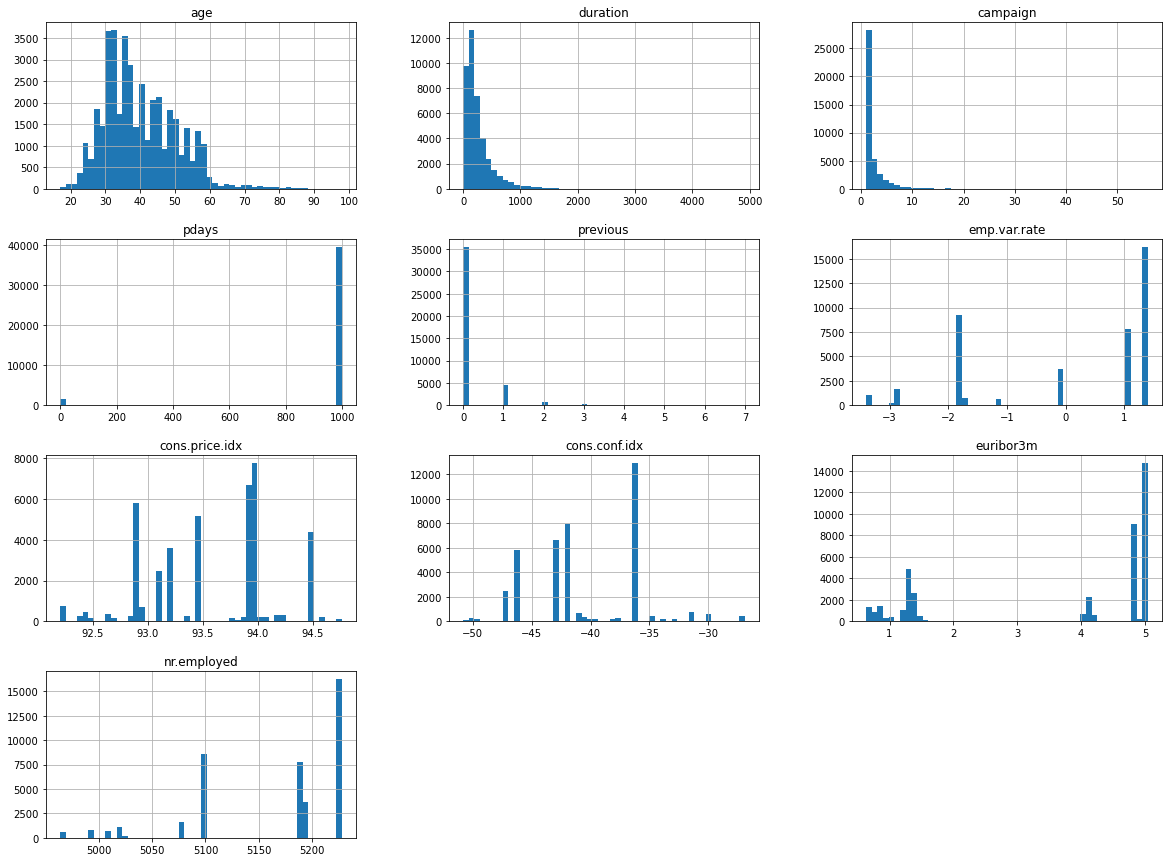

In [190]:
_ = df.hist(bins=50, figsize=(20,15))

### Prepare data for ML algorithms

Use functions were possible:

    - Reproducing on a new dataset is easier
    - Reusable on other projects
    - To transform the data for deployment
    - Can see which transformations work best

First, let's revert to a new clean training set, and separate features from labels (if applicable -- not in unsupervised learning)

In [191]:
df_copy = df.copy()
# Most algorithms cannot work with missing values. Three main ways to deal with them:
# 1. Drop rows
# 2. Drop features with NaNs
# 3. Fill missing values
# As we have very few missing values, let's drop the rows
print("Number of rows before dropping NaNs: %d" % len(df))
df_copy = df_copy.dropna()
print("Number of rows after dropping NaNs: %d" % len(df))
# Separate features from outcomes
y_df = df_copy.T.tail(1).T.copy()
#y_df = np.array(df['y'].copy()).reshape(-1,1)
X_df = df_copy.iloc[:,:-1].copy()

Number of rows before dropping NaNs: 41188
Number of rows after dropping NaNs: 41188


In [192]:
X_df.drop(columns=["duration"],inplace=True)

In [193]:
outcomesLabelEncoder = LabelEncoder()
y_df = y_df.apply(outcomesLabelEncoder.fit_transform)

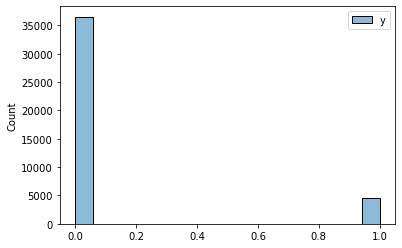

In [194]:
_ = sns.histplot(y_df, kde=False)

In [195]:
# Imbalance of the dataset
imbalance_dataset = y_df[y_df == 1.0].shape[1]/X_df.shape[0]
print(imbalance_dataset)

2.4278916189181315e-05


In [196]:
X_df = pd.get_dummies(X_df)

In [197]:
pd.set_option('display.max_info_rows', 400)
pd.set_option('display.max_info_columns', 400)
pd.set_option('display.max_columns', 400)
pd.set_option('display.max_rows', 400)
X_df.describe()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
count,41188.00000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000,41188.000000
mean,40.02406,2.567593,962.475454,0.172963,0.081886,93.575664,-40.502600,3.621291,5167.035911,0.253035,0.224677,0.035350,0.025736,0.070992,0.041760,0.034500,0.096363,0.021244,0.163713,0.024619,0.008012,0.111974,0.605225,0.280859,0.001942,0.101389,0.055647,0.146766,0.231014,0.000437,0.127294,0.295426,0.042027,0.791201,0.208726,0.000073,0.452122,0.024036,0.523842,0.824269,0.024036,0.151695,0.634748,0.365252,0.063902,0.149995,0.004419,0.174177,0.129115,0.013256,0.334296,0.099568,0.017432,0.013839,0.190031,0.206711,0.209357,0.196416,0.197485,0.103234,0.863431,0.033335
std,10.42125,2.770014,186.910907,0.494901,1.570960,0.578840,4.628198,1.734447,72.251528,0.434756,0.417375,0.184665,0.158348,0.256814,0.200042,0.182513,0.295092,0.144199,0.370019,0.154962,0.089152,0.315339,0.488808,0.449424,0.044029,0.301846,0.229242,0.353877,0.421486,0.020901,0.333306,0.456239,0.200653,0.406455,0.406403,0.008534,0.497708,0.153163,0.499437,0.380596,0.153163,0.358729,0.481507,0.481507,0.244581,0.357071,0.066328,0.379266,0.335332,0.114372,0.471750,0.299427,0.130877,0.116824,0.392330,0.404951,0.406855,0.397292,0.398106,0.304268,0.343396,0.179512
min,17.00000,1.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.00000,1.000000,999.000000,0.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
50%,38.00000,2.000000,999.000000

In [198]:
X_df.shape[1]

62

### Divide train and test sets.

In [199]:
# Create separate training and test sets. we'll use the training set for steps 3--6
X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.2, random_state=50,stratify=y_df)  
# by setting a random_state above, we make sure anytime we run this line we end up with the same train and test sets
print(len(X_train), len(X_test))

32950 8238


### Modeling

In [200]:
X_dummy = X_train
y_dummy = y_train
dummyClf = DummyClassifier(strategy="stratified")
scores_dummy = cross_val_score(estimator=dummyClf,X=X_dummy,y=y_dummy,scoring="f1",cv=10)
print(scores_dummy.mean())

0.10942847685743011


In [201]:
X_rf_150 = X_train
y_rf_150 = y_train
clf_rf_150 = RandomForestClassifier(n_estimators=150, max_depth=6)
scores_rf = cross_val_score(estimator=clf_rf_150,X=X_rf_150,y=np.array(y_rf_150).ravel(),scoring='f1',cv=10)
print(scores_rf.mean())

0.28081091317727025


In [202]:
X_rf_250 = X_train
y_rf_250 = y_train
clf_rf_250 = RandomForestClassifier(n_estimators=250, max_depth=6)
scores_rf = cross_val_score(estimator=clf_rf_250,X=X_rf_250,y=np.array(y_rf_250).ravel(),scoring='f1',cv=10)
print(scores_rf.mean())

0.28295514116529186


In [203]:
X_rf_400 = X_train
y_rf_400 = y_train
clf_rf_400 = RandomForestClassifier(n_estimators=400, max_depth=6,random_state=60)
clf_rf_400.fit(X=X_rf_400, y=np.array(y_rf_400).ravel())
clf_rf_400.feature_importances_

array([2.47076282e-02, 4.50659740e-03, 1.15682497e-01, 2.87293240e-02,
       9.29050584e-02, 5.68453072e-02, 7.84940682e-02, 1.49737632e-01,
       1.69919377e-01, 8.56148264e-04, 3.27309586e-03, 4.38195263e-04,
       3.86571428e-04, 6.15302164e-04, 2.87448784e-03, 6.56095665e-04,
       8.59028046e-04, 3.18895181e-03, 1.00529641e-03, 6.31726294e-04,
       5.54635738e-04, 6.59576372e-04, 1.16903572e-03, 1.38755589e-03,
       2.60958717e-04, 6.73756695e-04, 5.26945547e-04, 1.35372655e-03,
       1.12270057e-03, 5.47512807e-05, 8.52593558e-04, 2.08513614e-03,
       7.01839236e-04, 3.32695305e-03, 3.12857694e-03, 0.00000000e+00,
       9.19308856e-04, 4.49043519e-04, 9.38796571e-04, 8.21791264e-04,
       4.59400934e-04, 7.56852300e-04, 1.25400482e-02, 1.17527761e-02,
       6.58539082e-03, 1.69444239e-03, 1.23659833e-03, 1.18375177e-03,
       4.99961421e-03, 1.82820559e-02, 1.43100567e-02, 1.31131934e-03,
       1.57986806e-02, 6.34685952e-03, 1.05494663e-03, 3.74098968e-03,
      

In [204]:
X_train.head()

,age,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,job_admin.,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,marital_divorced,marital_married,marital_single,marital_unknown,education_basic.4y,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,education_unknown,default_no,default_unknown,default_yes,housing_no,housing_unknown,housing_yes,loan_no,loan_unknown,loan_yes,contact_cellular,contact_telephone,month_apr,month_aug,month_dec,month_jul,month_jun,month_mar,month_may,month_nov,month_oct,month_sep,day_of_week_fri,day_of_week_mon,day_of_week_thu,day_of_week_tue,day_of_week_wed,poutcome_failure,poutcome_nonexistent,poutcome_success
38445,22,3,6,1,-3.4,92.431,-26.9,0.730,5017.5,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,1
17713,36,1,999,0,1.4,93.918,-42.7,4.961,5228.1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0
30309,37,1,999,0,-1.8,93.075,-47.1,1.365,5099.1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0
25951,38,2,999,0,-0.1,93.200,-42.0,4.120,5195.8,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0
29064,41,3,999,0,-1.8,93.075,-47.1,1.405,5099.1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0


In [207]:
X_rf_100 = X_train
y_rf_100 = y_train
x_rf_100_test = X_test
y_rf_100_test = y_test
clf_rf_100 = RandomForestClassifier(n_estimators=100, max_depth=8,random_state=60)
clf_rf_100.fit(X=X_rf_100,y=np.array(y_rf_100).ravel())
y_predict = clf_rf_100.predict(x_rf_100_test)
score = f1_score(y_true=y_rf_100_test,y_pred=y_predict,average='binary')
print(score)


0.3360522022838499
